In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


# Fetching data

In [118]:
#forming a panda dataframe from the metadata file
#data=pd.read_csv("Datasets/metadata/IoT_Mem_Sound_All_Classes.csv")
data=pd.read_csv("Datasets/metadata/IoT_Mem_Sound_Classes.csv")

In [119]:
#head of the dataframe
data.head()

,File_Num,File_Name,Folder_Num,Class_ID,Class_Name,Type
0,1,Mem_FP_Benign_t0.wav,1,1,Fingerprint_App,Train
1,2,Mem_FP_Benign_t1.wav,1,1,Fingerprint_App,Train
2,3,Mem_FP_Benign_t2.wav,1,1,Fingerprint_App,Train
3,4,Mem_FP_Benign_t3.wav,1,1,Fingerprint_App,Train
4,5,Mem_FP_Benign_t4.wav,1,1,Fingerprint_App,Train


In [123]:
old_label = data["Class_ID"]
#print (old_label)

In [124]:
label = data.iloc[0:1]
#print (label)

In [125]:
new_label = data['Class_ID']
#print (new_label)

In [126]:
#count of datapoints in each of the folders
data["Folder_Num"].value_counts()

1    60
Name: Folder_Num, dtype: int64

# Visualizing data

In [127]:
from librosa import display
import librosa

In [11]:
#feature set
#This file is of a sample FP_App memory wave
y,sr=librosa.load("Datasets/audio/folder1/Mem_FP_Benign_t0.wav")
mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)
melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000)
chroma_stft=librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40)
chroma_cq =librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=40, n_chroma=40)
chroma_cens =librosa.feature.chroma_cens(y=y, sr=sr, bins_per_octave=40, n_chroma=40)
melspectrogram.shape,chroma_stft.shape,chroma_cq.shape,chroma_cens.shape,mfccs.shape


C:\Users\ramya\AppData\Local\Temp\ipykernel_10848\251779774.py:4: FutureWarning: Pass y=[ 2.3657915e-03  2.3385794e-03  2.7472255e-04 ...  1.2868360e-04
 -4.4518911e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(y, sr, n_mfcc=40)


((40, 21121), (40, 21121), (40, 21121), (40, 21121), (40, 21121))

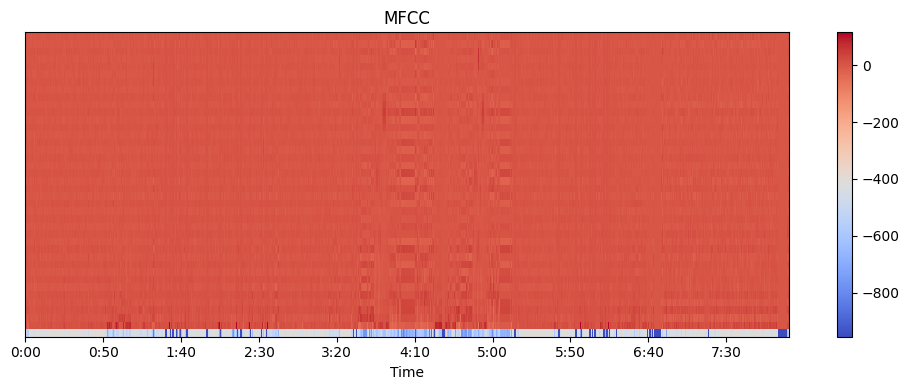

In [12]:
#MFCC of a sample audio wave
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

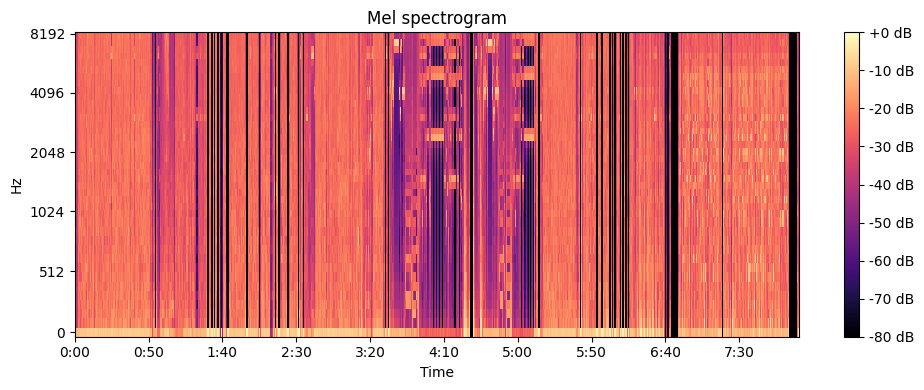

In [13]:
#Melspectrogram of a sample audio wave
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(melspectrogram,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

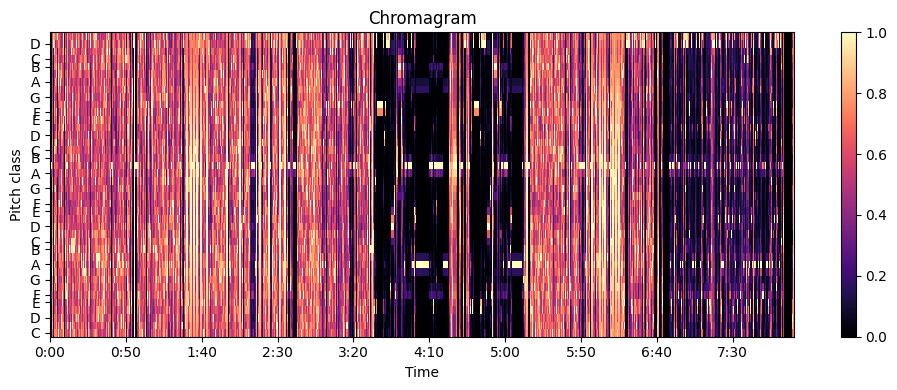

In [14]:
#Chromagram of a sample audio wave
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

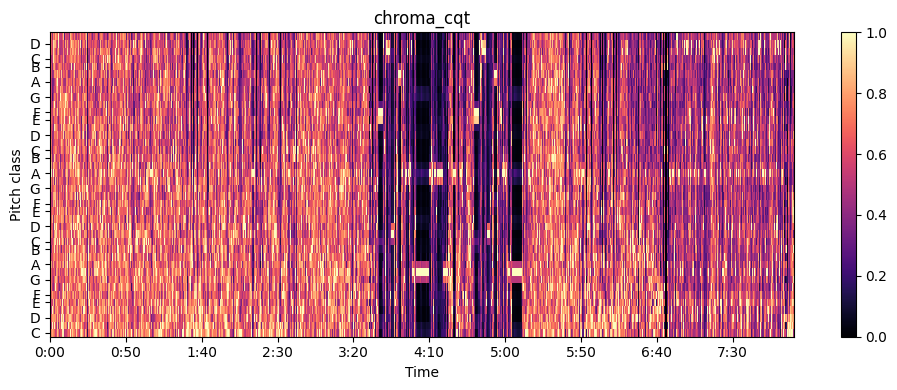

In [15]:
#Chroma cqt of a sample audio wave
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cqt')
plt.tight_layout()

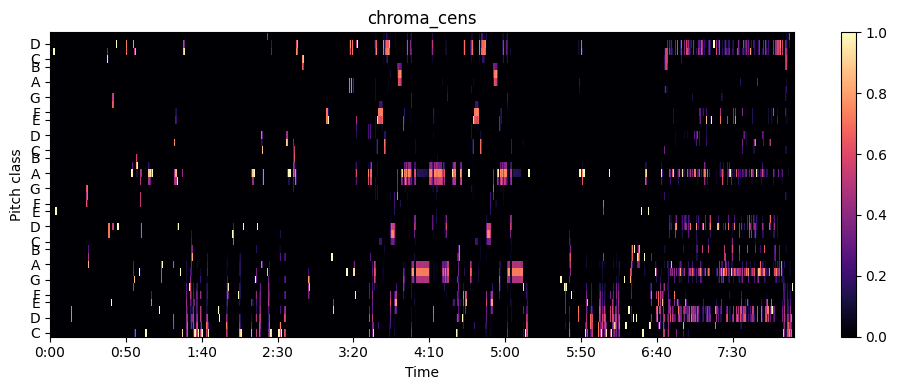

In [16]:
#Chroma cens of a sample audio wave
plt.figure(figsize=(10,4))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('chroma_cens')
plt.tight_layout()

# Preprocessing data

In [128]:
#feature set
y,sr=librosa.load("Datasets/audio/folder1/Aug_Mem_FP_Benign_t0.wav")
mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
chroma_cq = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=40, n_chroma=40).T,axis=0)
chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr, bins_per_octave=40, n_chroma=40).T,axis=0)
melspectrogram.shape,chroma_stft.shape,chroma_cq.shape,chroma_cens.shape,mfccs.shape

C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\582077023.py:3: FutureWarning: Pass y=[-2.3803711e-03 -2.3498535e-03 -3.0517578e-04 ... -1.5258789e-04
  3.0517578e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)


((40,), (40,), (40,), (40,), (40,))

In [129]:
#stacking and reshaping
features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(40,5))
features.shape

(40, 5)

In [98]:
#preprocessing using only mfcc
x_train=[]
x_test=[]
y_train=[]
y_test=[]
path="Datasets/test/folder"
for i in tqdm(range(len(data))):
    fold_no=str(data.iloc[i]["Folder_Num"])
    #print(fold_no)
    file=data.iloc[i]["File_Name"]
    #print(file)
    label = data.iloc[i]["Class_ID"]
    #print (label)
    filename=path + fold_no + "/" + file
    print(filename)
    #file_num = data.iloc[i]
    #print(filenum)
    Type = data.iloc[i]["Type"]
    print(Type)
    y,sr=librosa.load(filename)
    mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
    #print(mfccs.shape,mfccs.max(),mfccs.min())
    #print(file_num)
    if(fold_no =='1'):
        print(file_num['File_Num'])
        #print(type(file_num['File_Num']))
        if (file_num['File_Num'] < 16):
          x_train.append(mfccs)
          y_train.append(label)
        else:
          x_test.append(mfccs)
          y_test.append(label)
    else:
        x_test.append(mfccs)
        y_test.append(label)
        


  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

Datasets/test/folder1/Mem_FP_Benign_t0.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1827528897.py:19: FutureWarning: Pass y=[ 2.3657915e-03  2.3385794e-03  2.7472255e-04 ...  1.2868360e-04
 -4.4518911e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
  4%|███▏                                                                               | 1/26 [00:20<08:21, 20.04s/it]

(40,) 13.49421 -524.03723
File_Num                         1
File_Name     Mem_FP_Benign_t0.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 0, dtype: object
1
Datasets/test/folder1/Mem_FP_Benign_t1.wav


  8%|██████▍                                                                            | 2/26 [00:38<07:35, 18.97s/it]

(40,) 13.547895 -523.52
File_Num                         2
File_Name     Mem_FP_Benign_t1.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 1, dtype: object
2
Datasets/test/folder1/Mem_FP_Benign_t2.wav


 12%|█████████▌                                                                         | 3/26 [00:56<07:03, 18.43s/it]

(40,) 13.551705 -523.19977
File_Num                         3
File_Name     Mem_FP_Benign_t2.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 2, dtype: object
3
Datasets/test/folder1/Mem_FP_Benign_t3.wav


 15%|████████████▊                                                                      | 4/26 [01:13<06:37, 18.06s/it]

(40,) 13.554725 -523.12775
File_Num                         4
File_Name     Mem_FP_Benign_t3.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 3, dtype: object
4
Datasets/test/folder1/Mem_FP_Benign_t4.wav


 19%|███████████████▉                                                                   | 5/26 [01:30<06:13, 17.78s/it]

(40,) 13.559348 -523.13055
File_Num                         5
File_Name     Mem_FP_Benign_t4.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 4, dtype: object
5
Datasets/test/folder1/Mem_FP_Benign_t5.wav


 23%|███████████████████▏                                                               | 6/26 [01:49<06:04, 18.21s/it]

(40,) 13.556937 -523.12354
File_Num                         6
File_Name     Mem_FP_Benign_t5.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 5, dtype: object
6
Datasets/test/folder1/Mem_FP_Benign_t6.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1827528897.py:19: FutureWarning: Pass y=[2.3657915e-03 2.3385794e-03 2.7472255e-04 ... 4.0227129e-05 5.3068379e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 27%|██████████████████████▎                                                            | 7/26 [02:08<05:46, 18.24s/it]

(40,) 13.517319 -524.24677
File_Num                         7
File_Name     Mem_FP_Benign_t6.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 6, dtype: object
7
Datasets/test/folder1/Mem_FP_Benign_t7.wav


 31%|█████████████████████████▌                                                         | 8/26 [02:26<05:27, 18.21s/it]

(40,) 13.549024 -524.0374
File_Num                         8
File_Name     Mem_FP_Benign_t7.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 7, dtype: object
8
Datasets/test/folder1/Mem_FP_Benign_t8.wav


 35%|████████████████████████████▋                                                      | 9/26 [02:44<05:10, 18.24s/it]

(40,) 13.569392 -523.7919
File_Num                         9
File_Name     Mem_FP_Benign_t8.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 8, dtype: object
9
Datasets/test/folder1/Mem_FP_Benign_t9.wav


 38%|███████████████████████████████▌                                                  | 10/26 [03:02<04:49, 18.07s/it]

(40,) 13.577564 -523.7008
File_Num                        10
File_Name     Mem_FP_Benign_t9.wav
Folder_Num                       1
Class_ID                         1
Class_Name         Fingerprint_App
Name: 9, dtype: object
10
Datasets/test/folder1/Aug_Mem_FP_Benign_t0.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1827528897.py:19: FutureWarning: Pass y=[-2.3803711e-03 -2.3498535e-03 -3.0517578e-04 ... -1.5258789e-04
  3.0517578e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 42%|██████████████████████████████████▋                                               | 11/26 [03:03<03:11, 12.78s/it]

(40,) 13.529925 -523.4471
File_Num                            11
File_Name     Aug_Mem_FP_Benign_t0.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 10, dtype: object
11
Datasets/test/folder1/Aug_Mem_FP_Benign_t1.wav


 46%|█████████████████████████████████████▊                                            | 12/26 [03:03<02:07,  9.12s/it]

(40,) 13.582853 -522.93146
File_Num                            12
File_Name     Aug_Mem_FP_Benign_t1.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 11, dtype: object
12
Datasets/test/folder1/Aug_Mem_FP_Benign_t2.wav


 50%|█████████████████████████████████████████                                         | 13/26 [03:04<01:25,  6.58s/it]

(40,) 13.586108 -522.61163
File_Num                            13
File_Name     Aug_Mem_FP_Benign_t2.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 12, dtype: object
13
Datasets/test/folder1/Aug_Mem_FP_Benign_t3.wav


 54%|████████████████████████████████████████████▏                                     | 14/26 [03:05<00:57,  4.80s/it]

(40,) 13.589248 -522.53925
File_Num                            14
File_Name     Aug_Mem_FP_Benign_t3.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 13, dtype: object
14
Datasets/test/folder1/Aug_Mem_FP_Benign_t4.wav


 58%|███████████████████████████████████████████████▎                                  | 15/26 [03:05<00:39,  3.56s/it]

(40,) 13.593745 -522.54224
File_Num                            15
File_Name     Aug_Mem_FP_Benign_t4.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 14, dtype: object
15
Datasets/test/folder1/Aug_Mem_FP_Benign_t5.wav


 62%|██████████████████████████████████████████████████▍                               | 16/26 [03:06<00:26,  2.69s/it]

(40,) 13.591349 -522.5352
File_Num                            16
File_Name     Aug_Mem_FP_Benign_t5.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 15, dtype: object
16
Datasets/test/folder1/Aug_Mem_FP_Benign_t6.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1827528897.py:19: FutureWarning: Pass y=[-2.3803711e-03 -2.3498535e-03 -3.0517578e-04 ... -6.1035156e-05
 -6.1035156e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 65%|█████████████████████████████████████████████████████▌                            | 17/26 [03:07<00:18,  2.09s/it]

(40,) 13.551158 -523.65985
File_Num                            17
File_Name     Aug_Mem_FP_Benign_t6.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 16, dtype: object
17
Datasets/test/folder1/Aug_Mem_FP_Benign_t7.wav


 69%|████████████████████████████████████████████████████████▊                         | 18/26 [03:08<00:13,  1.68s/it]

(40,) 13.582909 -523.4505
File_Num                            18
File_Name     Aug_Mem_FP_Benign_t7.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 17, dtype: object
18
Datasets/test/folder1/Aug_Mem_FP_Benign_t8.wav


 73%|███████████████████████████████████████████████████████████▉                      | 19/26 [03:08<00:09,  1.39s/it]

(40,) 13.603712 -523.20496
File_Num                            19
File_Name     Aug_Mem_FP_Benign_t8.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 18, dtype: object
19
Datasets/test/folder1/Aug_Mem_FP_Benign_t9.wav


 77%|███████████████████████████████████████████████████████████████                   | 20/26 [03:09<00:07,  1.19s/it]

(40,) 13.611668 -523.11414
File_Num                            20
File_Name     Aug_Mem_FP_Benign_t9.wav
Folder_Num                           1
Class_ID                             1
Class_Name             Fingerprint_App
Name: 19, dtype: object
20
Datasets/test/folder0/Mem_RFID_Benign_t0.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1827528897.py:19: FutureWarning: Pass y=[ 2.3657915e-03  2.3385794e-03  2.7472255e-04 ...  1.2786180e-04
 -3.2072749e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 81%|██████████████████████████████████████████████████████████████████▏               | 21/26 [03:24<00:27,  5.45s/it]

(40,) 13.498591 -524.4354
File_Num                          21
File_Name     Mem_RFID_Benign_t0.wav
Folder_Num                         0
Class_ID                           0
Class_Name                  RFID_App
Name: 20, dtype: object
Datasets/test/folder0/Mem_RFID_Benign_t1.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1827528897.py:19: FutureWarning: Pass y=[2.3657915e-03 2.3385794e-03 2.7472255e-04 ... 9.5605756e-05 3.7887035e-06
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 85%|█████████████████████████████████████████████████████████████████████▍            | 22/26 [03:40<00:33,  8.42s/it]

(40,) 13.450815 -526.1251
File_Num                          22
File_Name     Mem_RFID_Benign_t1.wav
Folder_Num                         0
Class_ID                           0
Class_Name                  RFID_App
Name: 21, dtype: object
Datasets/test/folder0/Mem_RFID_Benign_t2.wav


 88%|████████████████████████████████████████████████████████████████████████▌         | 23/26 [03:55<00:31, 10.60s/it]

(40,) 13.452314 -526.0606
File_Num                          23
File_Name     Mem_RFID_Benign_t2.wav
Folder_Num                         0
Class_ID                           0
Class_Name                  RFID_App
Name: 22, dtype: object
Datasets/test/folder0/Mem_RFID_Benign_t3.wav


 92%|███████████████████████████████████████████████████████████████████████████▋      | 24/26 [04:11<00:24, 12.21s/it]

(40,) 13.454821 -526.0593
File_Num                          24
File_Name     Mem_RFID_Benign_t3.wav
Folder_Num                         0
Class_ID                           0
Class_Name                  RFID_App
Name: 23, dtype: object
Datasets/test/folder0/Mem_RFID_Benign_t4.wav


 96%|██████████████████████████████████████████████████████████████████████████████▊   | 25/26 [04:27<00:13, 13.14s/it]

(40,) 13.45582 -526.0366
File_Num                          25
File_Name     Mem_RFID_Benign_t4.wav
Folder_Num                         0
Class_ID                           0
Class_Name                  RFID_App
Name: 24, dtype: object
Datasets/test/folder0/Mem_RFID_Benign_t5.wav


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [04:42<00:00, 10.88s/it]

(40,) 13.456758 -526.0332
File_Num                          26
File_Name     Mem_RFID_Benign_t5.wav
Folder_Num                         0
Class_ID                           0
Class_Name                  RFID_App
Name: 25, dtype: object


In [130]:
#preprocessing using entire feature set
x_train=[]
x_test=[]
y_train=[]
y_test=[]
path="Datasets/test/folder"
for i in tqdm(range(len(data))):
    fold_no=str(data.iloc[i]["Folder_Num"])
    #print(fold_no)
    file=data.iloc[i]["File_Name"]
    #print(file)
    label = data.iloc[i]["Class_ID"]
    #print (label)
    filename=path + fold_no + "/" + file
    print(filename)
    Type = data.iloc[i]["Type"]
    #print(Type)
    #file_num = data.iloc[i]
    y,sr=librosa.load(filename)
    mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40,fmax=8000).T,axis=0)
    chroma_stft=np.mean(librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=40).T,axis=0)
    chroma_cq = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=40, n_chroma=40).T,axis=0)
    chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr, bins_per_octave=40, n_chroma=40).T,axis=0)
    features=np.reshape(np.vstack((mfccs,melspectrogram,chroma_stft,chroma_cq,chroma_cens)),(40,5))

    if(fold_no =='1'):
        if (Type == "Train"):
            x_train.append(features)
            y_train.append(label)
        else:
            x_test.append(features)
            y_test.append(label)

  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

Datasets/test/folder1/Mem_FP_Benign_t0.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[ 2.3657915e-03  2.3385794e-03  2.7472255e-04 ...  1.2868360e-04
 -4.4518911e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
  2%|█▎                                                                              | 1/60 [02:02<2:00:24, 122.45s/it]

Datasets/test/folder1/Mem_FP_Benign_t1.wav


  3%|██▋                                                                             | 2/60 [04:06<1:59:00, 123.11s/it]

Datasets/test/folder1/Mem_FP_Benign_t2.wav


  5%|████                                                                            | 3/60 [06:10<1:57:21, 123.53s/it]

Datasets/test/folder1/Mem_FP_Benign_t3.wav


  7%|█████▎                                                                          | 4/60 [08:16<1:56:19, 124.63s/it]

Datasets/test/folder1/Mem_FP_Benign_t4.wav


  8%|██████▋                                                                         | 5/60 [10:20<1:54:05, 124.46s/it]

Datasets/test/folder1/Mem_FP_Benign_t5.wav


 10%|████████                                                                        | 6/60 [11:30<1:35:12, 105.78s/it]

Datasets/test/folder1/Mem_FP_Benign_t6.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[2.3657915e-03 2.3385794e-03 2.7472255e-04 ... 4.0227129e-05 5.3068379e-05
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 12%|█████████▍                                                                       | 7/60 [12:09<1:14:22, 84.20s/it]

Datasets/test/folder1/Mem_FP_Benign_t7.wav


 13%|██████████▊                                                                      | 8/60 [12:51<1:01:10, 70.59s/it]

Datasets/test/folder1/Mem_FP_Benign_t8.wav


 15%|████████████▍                                                                      | 9/60 [13:31<51:51, 61.01s/it]

Datasets/test/folder1/Mem_FP_Benign_t9.wav


 17%|█████████████▋                                                                    | 10/60 [14:13<45:59, 55.19s/it]C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[-2.3803711e-03 -2.3498535e-03 -3.0517578e-04 ... -1.5258789e-04
  3.0517578e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)


Datasets/test/folder1/Aug_Mem_FP_Benign_t0.wav


 18%|███████████████                                                                   | 11/60 [14:34<36:40, 44.90s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t1.wav


 20%|████████████████▍                                                                 | 12/60 [14:55<29:53, 37.36s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t2.wav


 22%|█████████████████▊                                                                | 13/60 [15:14<25:07, 32.07s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t3.wav


 23%|███████████████████▏                                                              | 14/60 [15:33<21:31, 28.08s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t4.wav


 25%|████████████████████▌                                                             | 15/60 [15:53<19:07, 25.49s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t5.wav


 27%|█████████████████████▊                                                            | 16/60 [16:14<17:42, 24.16s/it]C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[-2.3803711e-03 -2.3498535e-03 -3.0517578e-04 ... -6.1035156e-05
 -6.1035156e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)


Datasets/test/folder1/Aug_Mem_FP_Benign_t6.wav


 28%|███████████████████████▏                                                          | 17/60 [16:34<16:21, 22.84s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t7.wav


 30%|████████████████████████▌                                                         | 18/60 [16:53<15:21, 21.94s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t8.wav


 32%|█████████████████████████▉                                                        | 19/60 [17:15<14:51, 21.74s/it]

Datasets/test/folder1/Aug_Mem_FP_Benign_t9.wav


 33%|███████████████████████████▎                                                      | 20/60 [17:36<14:21, 21.53s/it]

Datasets/test/folder1/Mem_RFID_Benign_t0.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[ 2.3657915e-03  2.3385794e-03  2.7472255e-04 ...  1.2786180e-04
 -3.2072749e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 35%|████████████████████████████▋                                                     | 21/60 [18:10<16:28, 25.36s/it]

Datasets/test/folder1/Mem_RFID_Benign_t1.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[2.3657915e-03 2.3385794e-03 2.7472255e-04 ... 9.5605756e-05 3.7887035e-06
 0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 37%|██████████████████████████████                                                    | 22/60 [18:45<17:51, 28.18s/it]

Datasets/test/folder1/Mem_RFID_Benign_t2.wav


 38%|███████████████████████████████▍                                                  | 23/60 [19:21<18:46, 30.44s/it]

Datasets/test/folder1/Mem_RFID_Benign_t3.wav


 40%|████████████████████████████████▊                                                 | 24/60 [19:55<18:54, 31.52s/it]

Datasets/test/folder1/Mem_RFID_Benign_t4.wav


 42%|██████████████████████████████████▏                                               | 25/60 [20:30<19:04, 32.70s/it]

Datasets/test/folder1/Mem_RFID_Benign_t5.wav


 43%|███████████████████████████████████▌                                              | 26/60 [21:05<18:49, 33.23s/it]

Datasets/test/folder1/Mem_RFID_Benign_t6.wav


 45%|████████████████████████████████████▉                                             | 27/60 [21:39<18:32, 33.70s/it]

Datasets/test/folder1/Mem_RFID_Benign_t7.wav


 47%|██████████████████████████████████████▎                                           | 28/60 [22:13<18:02, 33.84s/it]

Datasets/test/folder1/Mem_RFID_Benign_t8.wav


 48%|███████████████████████████████████████▋                                          | 29/60 [22:48<17:34, 34.01s/it]

Datasets/test/folder1/Mem_RFID_Benign_t9.wav


 50%|█████████████████████████████████████████                                         | 30/60 [23:24<17:20, 34.67s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t0.wav


 52%|██████████████████████████████████████████▎                                       | 31/60 [23:42<14:23, 29.76s/it]C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[-2.3803711e-03 -2.3498535e-03 -3.0517578e-04 ... -1.2207031e-04
 -3.0517578e-05  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)


Datasets/test/folder1/Aug_Mem_RFID_Benign_t1.wav


 53%|███████████████████████████████████████████▋                                      | 32/60 [24:00<12:13, 26.18s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t2.wav


 55%|█████████████████████████████████████████████                                     | 33/60 [24:19<10:48, 24.02s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t3.wav


 57%|██████████████████████████████████████████████▍                                   | 34/60 [24:37<09:35, 22.13s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t4.wav


 58%|███████████████████████████████████████████████▊                                  | 35/60 [24:55<08:39, 20.77s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t5.wav


 60%|█████████████████████████████████████████████████▏                                | 36/60 [25:14<08:05, 20.23s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t6.wav


 62%|██████████████████████████████████████████████████▌                               | 37/60 [25:31<07:28, 19.49s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t7.wav


 63%|███████████████████████████████████████████████████▉                              | 38/60 [25:50<07:00, 19.11s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t8.wav


 65%|█████████████████████████████████████████████████████▎                            | 39/60 [26:08<06:35, 18.85s/it]

Datasets/test/folder1/Aug_Mem_RFID_Benign_t9.wav


 67%|██████████████████████████████████████████████████████▋                           | 40/60 [26:27<06:19, 18.98s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t0.wav


C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[ 2.3657915e-03  2.3385794e-03  2.7472255e-04 ... -7.3147457e-05
  1.5334757e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)
 68%|████████████████████████████████████████████████████████                          | 41/60 [27:15<08:46, 27.72s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t1.wav


 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [28:01<09:54, 33.04s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t2.wav


 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [28:48<10:36, 37.43s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t3.wav


 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [29:36<10:48, 40.54s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t4.wav


 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [30:24<10:40, 42.70s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t5.wav


 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [31:11<10:15, 43.99s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t6.wav


 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [32:00<09:51, 45.50s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t7.wav


 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [32:48<09:15, 46.29s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t8.wav


 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [33:36<08:34, 46.79s/it]

Datasets/test/folder1/Mem_Smart_Fan_Benign_t9.wav


 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [34:24<07:51, 47.13s/it]C:\Users\ramya\AppData\Local\Temp\ipykernel_20656\1346812183.py:20: FutureWarning: Pass y=[-2.3803711e-03 -2.3498535e-03 -3.0517578e-04 ...  6.1035156e-05
 -1.8310547e-04  0.0000000e+00], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=40).T,axis=0)


Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t0.wav


 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [34:48<06:02, 40.30s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t1.wav


 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [35:14<04:47, 35.94s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t2.wav


 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [35:41<03:52, 33.21s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t3.wav


 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [36:05<03:03, 30.64s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t4.wav


 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [36:30<02:23, 28.74s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t5.wav


 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [36:54<01:49, 27.45s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t6.wav


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [37:19<01:20, 26.71s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t7.wav


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [37:43<00:51, 25.92s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t8.wav


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [38:08<00:25, 25.63s/it]

Datasets/test/folder1/Aug_Mem_Smart_Fan_Benign_t9.wav


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [38:33<00:00, 38.56s/it]


In [131]:
len(x_train) + len(x_test)

60

In [132]:
len(x_train)

45

In [133]:
len(x_test)

15

In [134]:
len(data)

60

In [135]:
#converting the lists into numpy arrays
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((45, 40, 5), (15, 40, 5), (45,), (15,))

In [136]:
#reshaping into 2d to save in csv format
x_train_2d=np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
x_test_2d=np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
x_train_2d.shape,x_test_2d.shape

((45, 200), (15, 200))

# Processing Stored Data

In [137]:
#saving the data numpy arrays
np.savetxt("train_data.csv", x_train_2d, delimiter=",")
np.savetxt("test_data.csv",x_test_2d,delimiter=",")
np.savetxt("train_labels.csv",y_train,delimiter=",")
np.savetxt("test_labels.csv",y_test,delimiter=",")